# Capstone: Malaria Cell Classification

-----------------------------

**Author**: Ciara Adkins

**Email**: adkins.ciara@gmail.com

**LinkedIn**: https://www.linkedin.com/in/ciara-adkins/

-----------------------------

This is a capstone project on using  deep learning techniques for image processing.

Completed as a part of the MIT Applied Data Science course in the Spring of 2022. Full e-portfolio can be viewed here: https://eportfolio.mygreatlearning.com/ciara-adkins

# <b> Problem Definition </b>

## Context
* Around 627k people died from malaria in 2020
* Many malaria causing parasites have developed resistance to common antimalarial drugs
* Potential fatal, but is curable with early and accurate intervention

## Problem
* Currently, diagnosis of malarial infection in a laboratory is a tedious and manual process
* The results can differ based on the observer

## Goals
* Increase the rate of early intervention
* Increase the diagnostic accuracy, consistency, and reliability
* Decrease the amount of time that scientists have to dedicate towards diagnosis that can now be spent on other projects

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>
* Each entry in the dataset consists of a 64x64 pixel microscopic image of an individual cells (in color aka RGB)
* Additionally, each entry is “labeled” either 1 or 0 meaning that the cell has been categorized as parasitized (1) or healthy (0)

**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>



In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Let us load the data</b>

In [ ]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/mit_adsp_2022/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [ ]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [ ]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b>Normalize the images

In [ ]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images / 255.0).astype('float32')
test_images = (test_images / 255.0).astype('float32')

###<b> Processing Images using Gaussian Blurring

After running nearly 30 variations of the models with varying inputs and parameters, gaussian blurred images performed the best in terms of accuracy and reduction of false negatives.

In [ ]:
# convert train data to gaussian blurred images
import cv2
gbx_train=[]  ## to hold the blurred images
for i in np.arange(0,len(train_images),1):
  b= cv2.GaussianBlur(train_images[i], (5, 5), 0)
  gbx_train.append(b)
gbx_train=np.array(gbx_train)

In [ ]:
# convert test data to gaussian blurred images
gbx_test=[]  ## to hold the blurred images
for i in np.arange(0,len(test_images),1):
  b= cv2.GaussianBlur(test_images[i], (5, 5), 0)
  gbx_test.append(b)
gbx_test=np.array(gbx_test)

###<B>One Hot Encoding on the train and test labels

In [ ]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

###<B> Building the model

In [ ]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#creating sequential model
model1_gbx1=Sequential()

# Build the model here
model1_gbx1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model1_gbx1.add(MaxPooling2D(pool_size=2))
model1_gbx1.add(Dropout(0.2))
model1_gbx1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1_gbx1.add(MaxPooling2D(pool_size=2))
model1_gbx1.add(Dropout(0.2))
model1_gbx1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1_gbx1.add(MaxPooling2D(pool_size=2))
model1_gbx1.add(Dropout(0.2))
model1_gbx1.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model1_gbx1.add(MaxPooling2D(pool_size=2))
model1_gbx1.add(Dropout(0.2))
model1_gbx1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1_gbx1.add(MaxPooling2D(pool_size=2))
model1_gbx1.add(Dropout(0.2))

model1_gbx1.add(Flatten())

model1_gbx1.add(Dense(512,activation="relu"))
model1_gbx1.add(Dropout(0.4))
model1_gbx1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

model1_gbx1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

In [ ]:
model1_gbx1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [ ]:
history_gbx1=model1_gbx1.fit(gbx_train,train_labels,batch_size=64,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
312/312 [==============================] - 85s 268ms/step - loss: 0.4411 - accuracy: 0.7705 - val_loss: 0.1155 - val_accuracy: 0.9806
Epoch 2/20
312/312 [==============================] - 79s 254ms/step - loss: 0.1114 - accuracy: 0.9616 - val_loss: 0.0860 - val_accuracy: 0.9826
Epoch 3/20
312/312 [==============================] - 78s 252ms/step - loss: 0.0903 - accuracy: 0.9693 - val_loss: 0.0501 - val_accuracy: 0.9896
Epoch 4/20
312/312 [==============================] - 79s 253ms/step - loss: 0.0821 - accuracy: 0.9711 - val_loss: 0.0552 - val_accuracy: 0.9860
Epoch 5/20
312/312 [==============================] - 79s 253ms/step - loss: 0.0791 - accuracy: 0.9742 - val_loss: 0.0374 - val_accuracy: 0.9902
Epoch 6/20
312/312 [==============================] - 79s 255ms/step - loss: 0.0785 - accuracy: 0.9730 - val_loss: 0.0700 - val_accuracy: 0.9778
Epoch 7/20
312/312 [==============================] - 79s 254ms/step - loss: 0.0765 - accuracy: 0.9741 - val_loss: 0.0379 - val_ac

In [ ]:
accuracy_gbx1 = model1_gbx1.evaluate(gbx_test, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy_gbx1[1])

82/82 [==============================] - 3s 34ms/step - loss: 0.0592 - accuracy: 0.9831

 Test_Accuracy:- 0.9830769300460815


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1300
           1       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



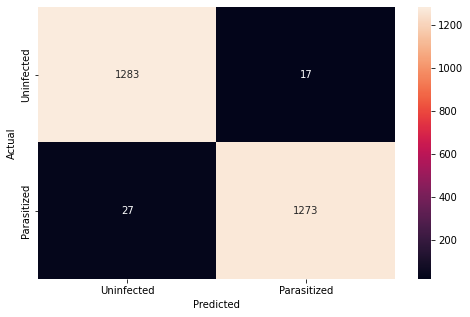

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model1_gbx1.predict(gbx_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

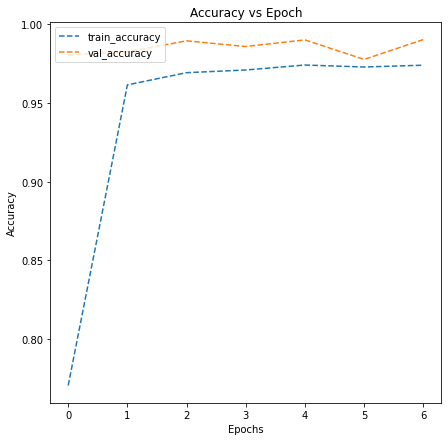

In [ ]:
plot_accuracy(history_gbx1)

###<B> Improving the model

In [ ]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

Add some more layers to the previous model:

In [ ]:
#creating sequential model
model1_gbx2=Sequential()

# Build the model here
model1_gbx2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model1_gbx2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1_gbx2.add(MaxPooling2D(pool_size=2))
model1_gbx2.add(BatchNormalization())
model1_gbx2.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model1_gbx2.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model1_gbx2.add(MaxPooling2D(pool_size=2))
model1_gbx2.add(BatchNormalization())
model1_gbx2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1_gbx2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1_gbx2.add(MaxPooling2D(pool_size=2))
model1_gbx2.add(BatchNormalization())
model1_gbx2.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model1_gbx2.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model1_gbx2.add(MaxPooling2D(pool_size=2))
model1_gbx2.add(BatchNormalization())
model1_gbx2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1_gbx2.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1_gbx2.add(MaxPooling2D(pool_size=2))
model1_gbx2.add(BatchNormalization())
model1_gbx2.add(Dropout(0.2))

model1_gbx2.add(Flatten())

model1_gbx2.add(Dense(512,activation="relu"))
model1_gbx2.add(Dropout(0.4))
model1_gbx2.add(Dense(2,activation="softmax"))

model1_gbx2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4128      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
model1_gbx2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [ ]:
history_gbx2=model1_gbx2.fit(gbx_train,train_labels,batch_size=64,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
312/312 [==============================] - 237s 756ms/step - loss: 0.2332 - accuracy: 0.8977 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 2/20
312/312 [==============================] - 236s 756ms/step - loss: 0.0721 - accuracy: 0.9755 - val_loss: 0.0192 - val_accuracy: 0.9966
Epoch 3/20
312/312 [==============================] - 235s 754ms/step - loss: 0.0608 - accuracy: 0.9790 - val_loss: 0.0397 - val_accuracy: 0.9946
Epoch 4/20
312/312 [==============================] - 236s 756ms/step - loss: 0.0546 - accuracy: 0.9797 - val_loss: 0.0634 - val_accuracy: 0.9764


In [ ]:
accuracy_gbx2 = model1_gbx2.evaluate(gbx_test, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy_gbx2[1])

82/82 [==============================] - 8s 94ms/step - loss: 0.0436 - accuracy: 0.9888

 Test_Accuracy:- 0.9888461828231812


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1300
           1       0.98      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



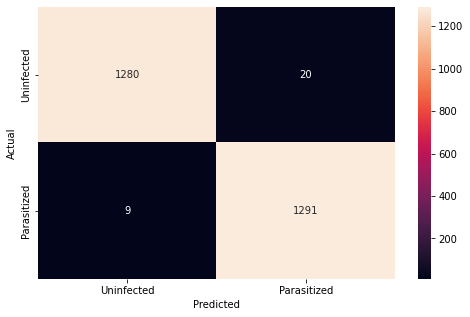

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model1_gbx2.predict(gbx_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

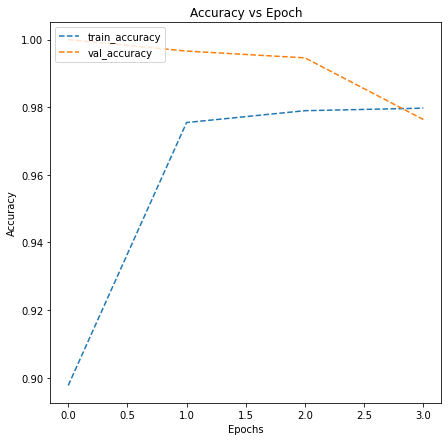

In [ ]:
plot_accuracy(history_gbx2)

###<b>Visualize Some of the Falsely Classified Images</b>

In [ ]:
right_pred = pred == y_true

In [ ]:
right_pred = np.array(right_pred)

In [ ]:
right_pred

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
right_pred[0]

True

In [ ]:
wrong_pred_im = []
wrong_pred_lab = []
for i in np.arange(0,len(test_images),1):
  if right_pred[i] == False:
    wrong_pred_im.append(test_images[i])
    wrong_pred_lab.append(test_labels[i])

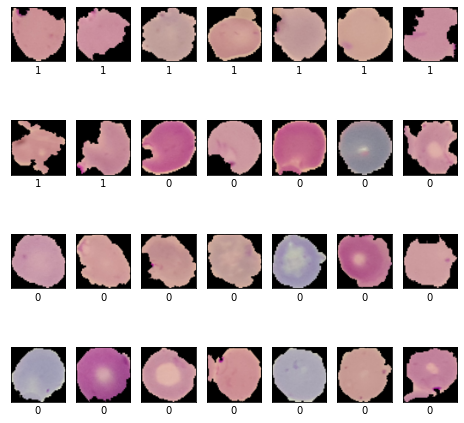

In [ ]:
plt.figure(figsize=(8,8))
for i in range(28):
    plt.subplot(4,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(wrong_pred_im[i], cmap=plt.cm.binary)
    plt.xlabel(wrong_pred_lab[i])
plt.show()